### Light Field Parameters

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/regression-rumble-ndc-2025/df_merged.csv')

In [3]:
# Convert date column to datetime
df['depth_reading_time'] = pd.to_datetime(df['depth_reading_time'])

# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

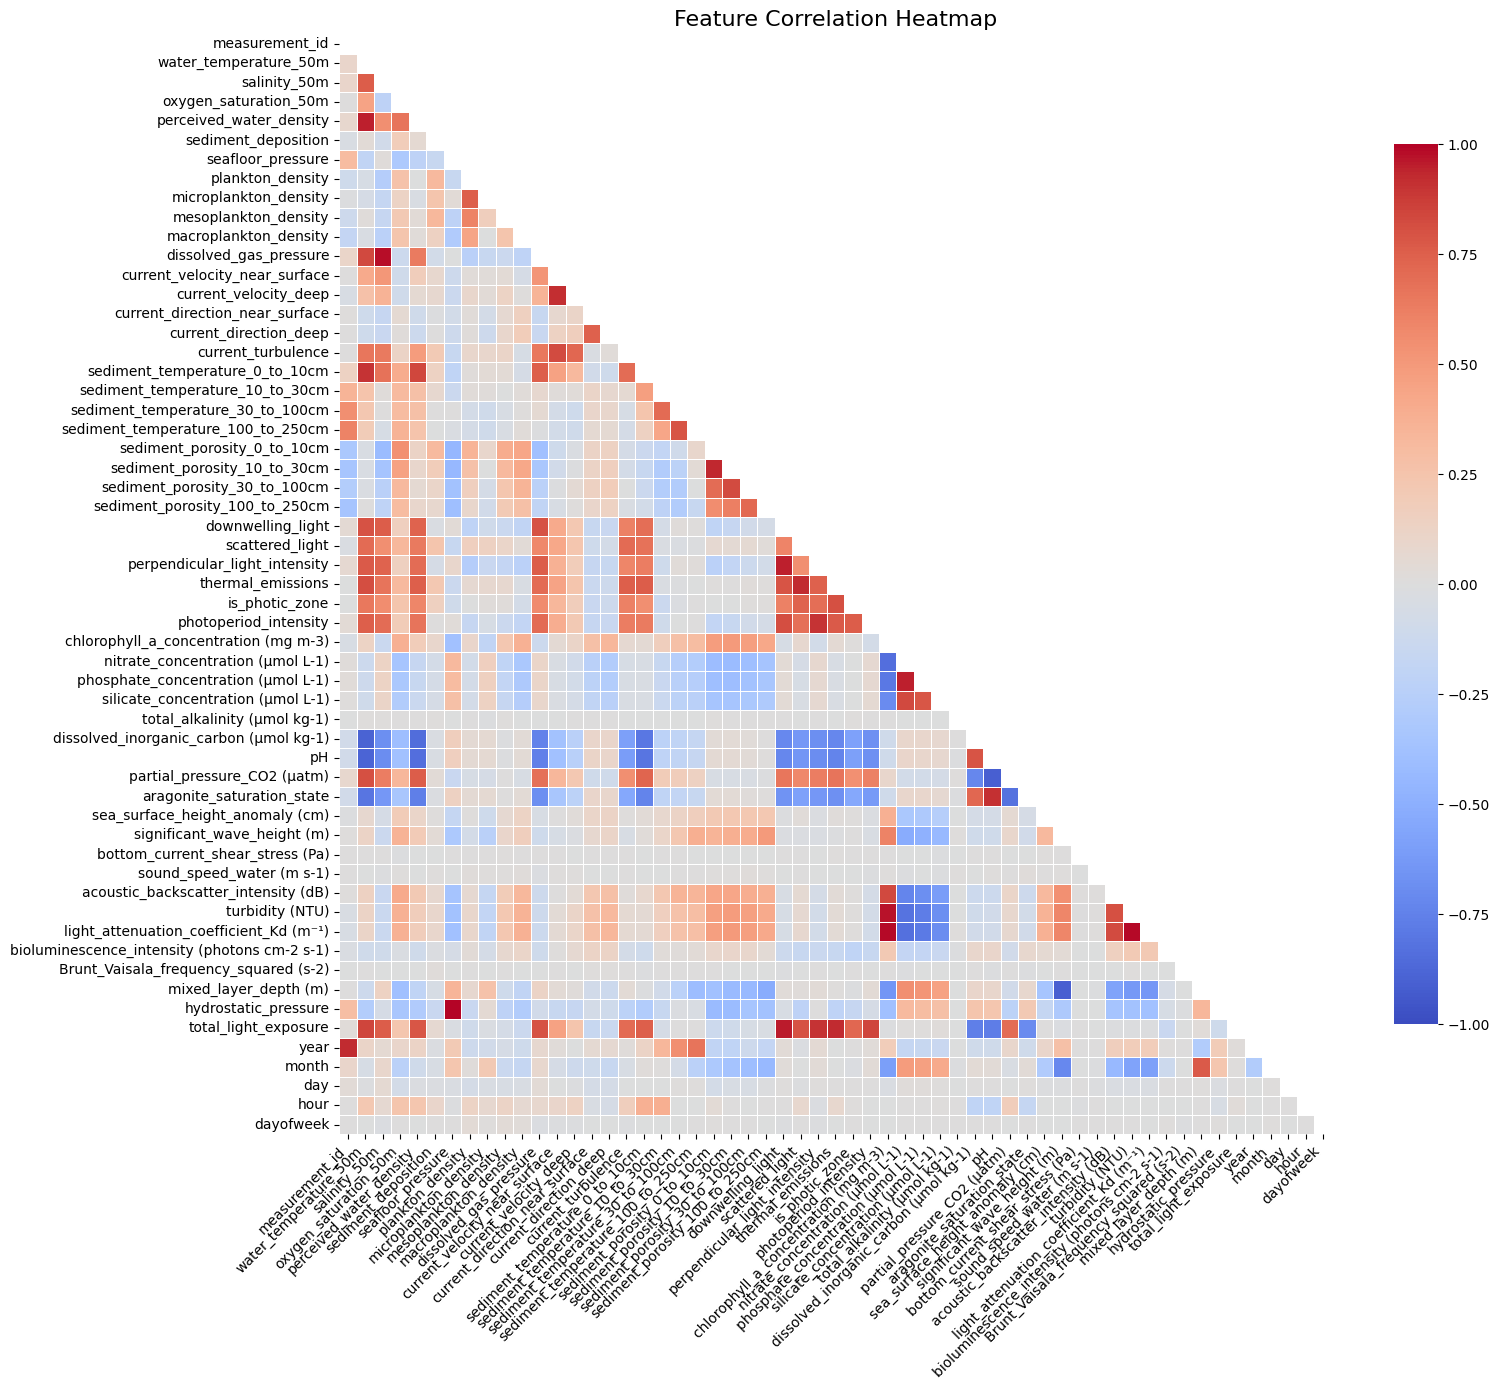

In [4]:
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Calculate VIF for numeric columns
# First, drop NaN values
df_vif = df[numeric_cols].dropna()

# If there are too many columns, select a subset
if len(df_vif.columns) > 30:
    # Remove year, month, day, hour columns from VIF analysis as they're temporal
    vif_cols = [col for col in df_vif.columns if col not in ['year', 'month', 'day', 'hour', 'dayofweek', 'measurement_id']]
    
    # Take columns with fewer NaN values (most complete data)
    vif_cols = sorted(vif_cols, key=lambda col: df[col].isna().sum())[:25]
    df_vif = df[vif_cols].dropna()

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# Sort by VIF and display
vif_data = vif_data.sort_values("VIF", ascending=False)
print("Variance Inflation Factors (VIF):")
print(vif_data)

# Identify features with high multicollinearity (VIF > 10)
high_vif = vif_data[vif_data["VIF"] > 10]
print("\nFeatures with high multicollinearity (VIF > 10):")
print(high_vif)

Variance Inflation Factors (VIF):
                                   feature           VIF
5         sediment_temperature_30_to_100cm  1.535184e+06
20       sediment_temperature_100_to_250cm  1.161161e+06
16         sediment_temperature_10_to_30cm  2.716622e+05
13               sound_speed_water (m s-1)  2.442441e+04
4             total_alkalinity (µmol kg-1)  1.092034e+04
22  light_attenuation_coefficient_Kd (m⁻¹)  6.384922e+02
3                  perceived_water_density  4.469930e+02
14     acoustic_backscatter_intensity (dB)  3.776501e+02
24       silicate_concentration (µmol L-1)  1.945927e+02
8         nitrate_concentration (µmol L-1)  1.813868e+02
1     chlorophyll_a_concentration (mg m-3)  1.806672e+02
6                          turbidity (NTU)  1.743813e+02
17          sediment_porosity_100_to_250cm  1.416211e+02
23            sediment_porosity_10_to_30cm  1.364643e+02
21             sediment_porosity_0_to_10cm  1.271780e+02
0                     total_light_exposure  4.457759e+

#### Night Time

In [6]:
# Kolom yang akan diubah
features = [
    'downwelling_light',
    'scattered_light',
    'perpendicular_light_intensity',
    'photoperiod_intensity',
    'is_photic_zone',
    'total_light_exposure',
    'thermal_emissions'
]

# 1. Ketika 'hour' di luar rentang 6-18, set kolom target menjadi 0
# Kondisi: hour < 6 ATAU hour > 18
night_hours_condition = (df['hour'] < 6) | (df['hour'] > 18)
df.loc[night_hours_condition, features] = 0

# 2. Ketika 'hour' di dalam rentang 6-18, set 'is_photic_zone' menjadi 1
# Kondisi: 6 <= hour <= 18
day_hours_condition = (df['hour'] >= 6) & (df['hour'] <= 18)
df.loc[day_hours_condition, 'is_photic_zone'] = 1

# Untuk verifikasi (opsional)
print(df[['hour'] + features].head(10))
print(df[df['hour'] == 5][['hour'] + features].head())
print(df[df['hour'] == 7][['hour'] + features].head())
print(df[df['hour'] == 19][['hour'] + features].head())

   hour  downwelling_light  scattered_light  perpendicular_light_intensity  \
0     0                0.0              0.0                            0.0   
1     1                0.0              0.0                            0.0   
2     2                0.0              0.0                            0.0   
3     3                0.0              0.0                            0.0   
4     4                0.0              0.0                            0.0   
5     5                0.0              0.0                            0.0   
6     6                1.0             12.0                            NaN   
7     7               69.0              NaN                          285.1   
8     8              257.0            116.0                          551.8   
9     9              484.0            135.0                          731.9   

   photoperiod_intensity  is_photic_zone  total_light_exposure  \
0                    0.0             0.0                   0.0   
1        

#### Day Time

In [7]:
# 1. Filter DataFrame untuk jam 6 hingga 18
df_daytime = df[(df['hour'] >= 6) & (df['hour'] <= 18)].copy()

In [8]:
print("Missing values SEBELUM pengisian berbasis rumus:")
print(df[['total_light_exposure', 'scattered_light', 'downwelling_light']].isnull().sum())
print("-" * 30)

# 1. Mengisi 'downwelling_light'
# Kondisi: 'downwelling_light' adalah NaN, DAN 'total_light_exposure' tidak NaN, DAN 'scattered_light' tidak NaN
condition_fill_downwelling = (
    df['downwelling_light'].isnull() &
    df['total_light_exposure'].notnull() &
    df['scattered_light'].notnull()
)

# Hitung berapa banyak yang akan diisi (untuk informasi)
num_filled_downwelling = condition_fill_downwelling.sum()

if num_filled_downwelling > 0:
    df.loc[condition_fill_downwelling, 'downwelling_light'] = \
        df.loc[condition_fill_downwelling, 'total_light_exposure'] - df.loc[condition_fill_downwelling, 'scattered_light']
    print(f"Mengisi {num_filled_downwelling} nilai NaN pada 'downwelling_light' menggunakan rumus.")
else:
    print("Tidak ada nilai NaN pada 'downwelling_light' yang dapat diisi dengan rumus saat ini.")

Missing values SEBELUM pengisian berbasis rumus:
total_light_exposure     459
scattered_light          962
downwelling_light       2370
dtype: int64
------------------------------
Mengisi 1860 nilai NaN pada 'downwelling_light' menggunakan rumus.


In [9]:
# 2. Mengisi 'scattered_light'
# Kondisi: 'scattered_light' adalah NaN, DAN 'total_light_exposure' tidak NaN, DAN 'downwelling_light' tidak NaN
# Perhatikan bahwa 'downwelling_light' di sini bisa jadi adalah nilai yang baru saja diisi pada langkah 1
condition_fill_scattered = (
    df['scattered_light'].isnull() &
    df['total_light_exposure'].notnull() &
    df['downwelling_light'].notnull()
)

# Hitung berapa banyak yang akan diisi (untuk informasi)
num_filled_scattered = condition_fill_scattered.sum()

if num_filled_scattered > 0:
    df.loc[condition_fill_scattered, 'scattered_light'] = \
        df.loc[condition_fill_scattered, 'total_light_exposure'] - df.loc[condition_fill_scattered, 'downwelling_light']
    print(f"Mengisi {num_filled_scattered} nilai NaN pada 'scattered_light' menggunakan rumus.")
else:
    print("Tidak ada nilai NaN pada 'scattered_light' yang dapat diisi dengan rumus saat ini.")

print("-" * 30)
print("Missing values SETELAH pengisian berbasis rumus:")
print(df[['total_light_exposure', 'scattered_light', 'downwelling_light']].isnull().sum())

Mengisi 678 nilai NaN pada 'scattered_light' menggunakan rumus.
------------------------------
Missing values SETELAH pengisian berbasis rumus:
total_light_exposure    459
scattered_light         284
downwelling_light       510
dtype: int64


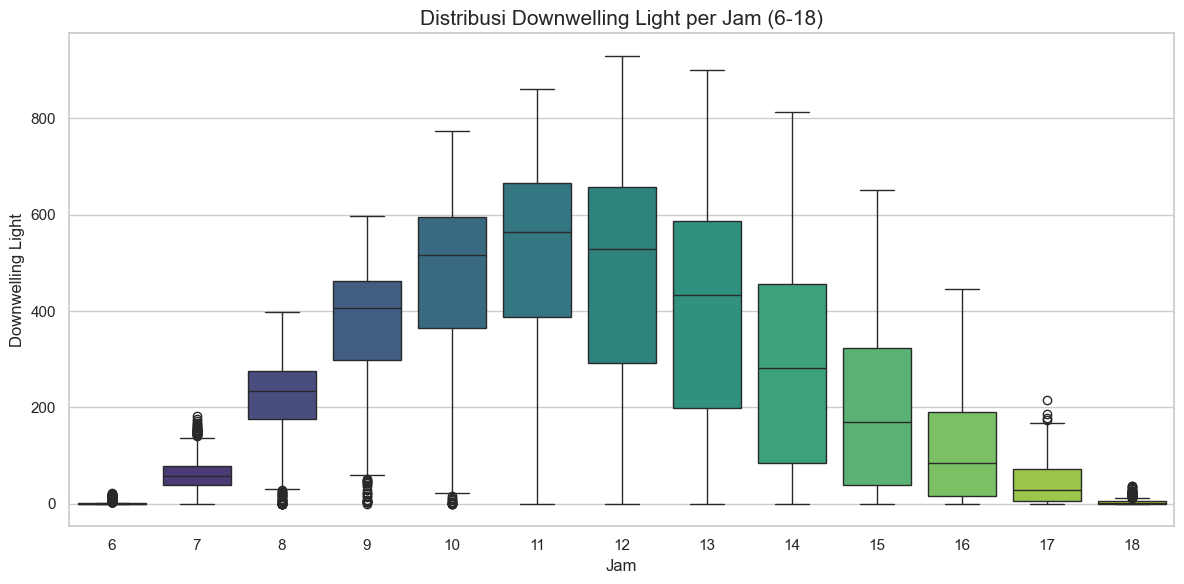

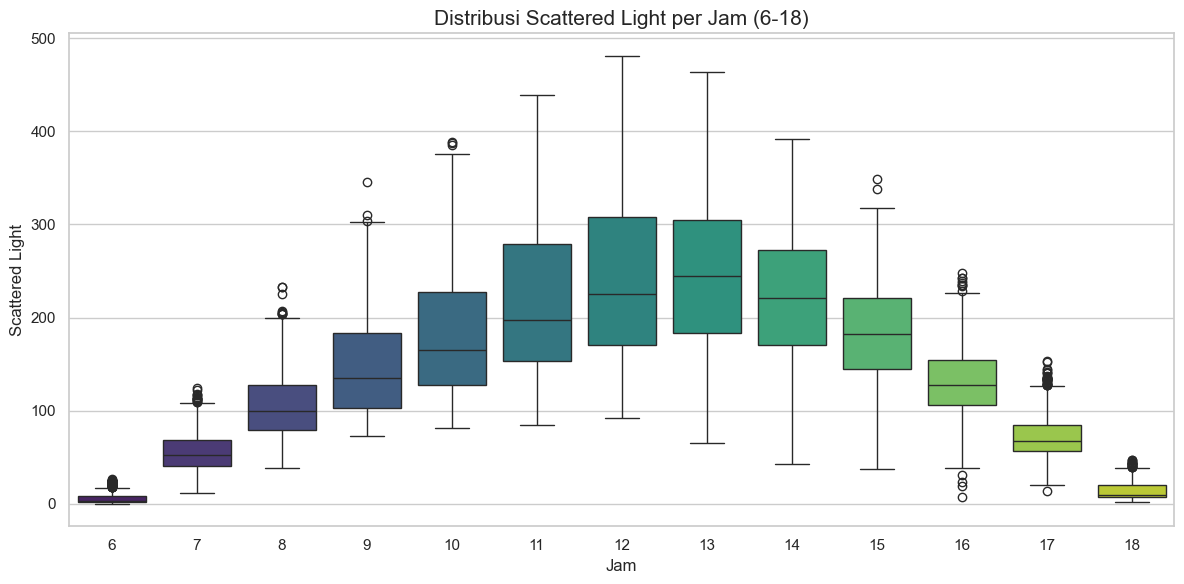

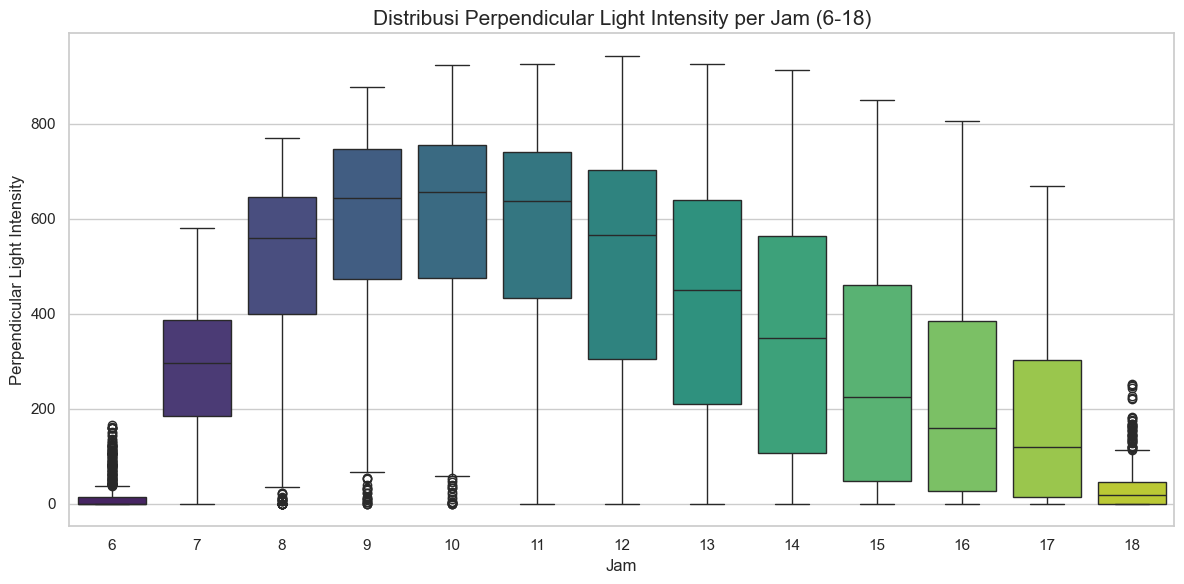

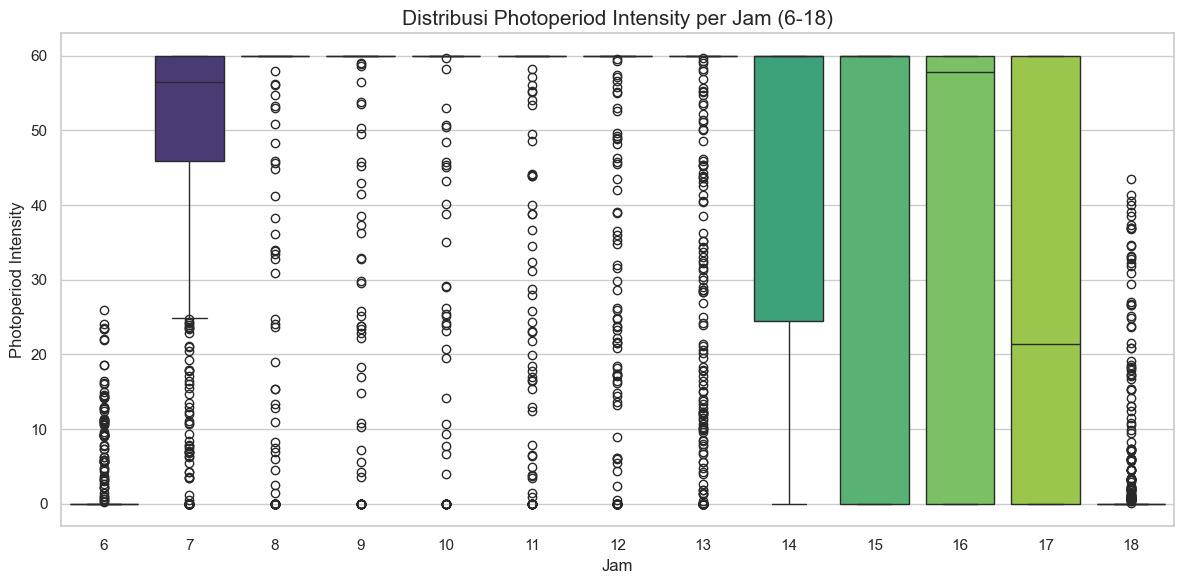

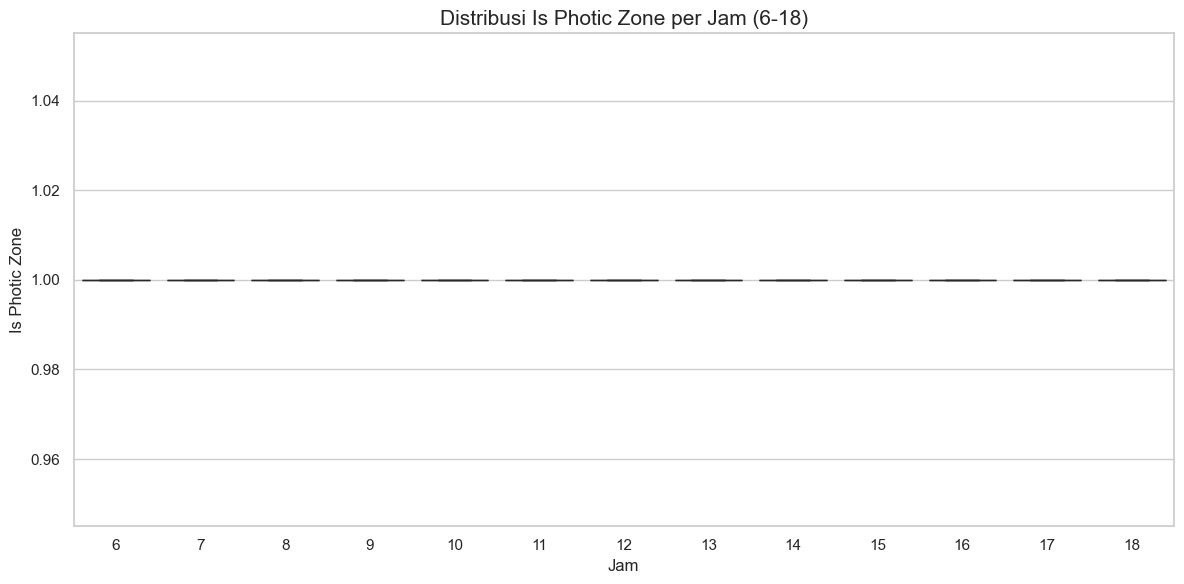

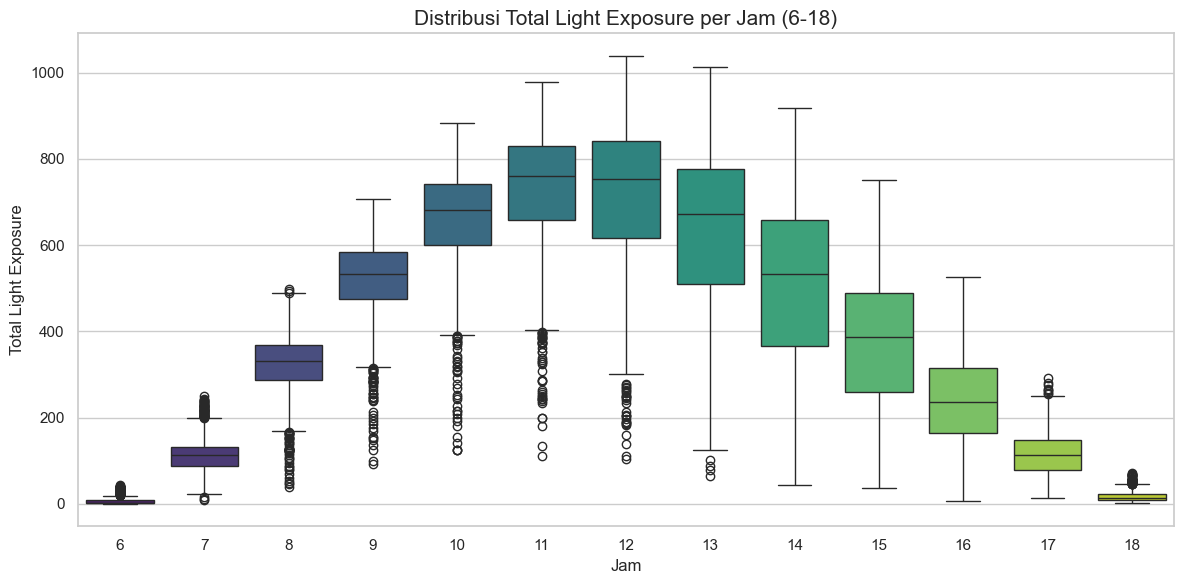

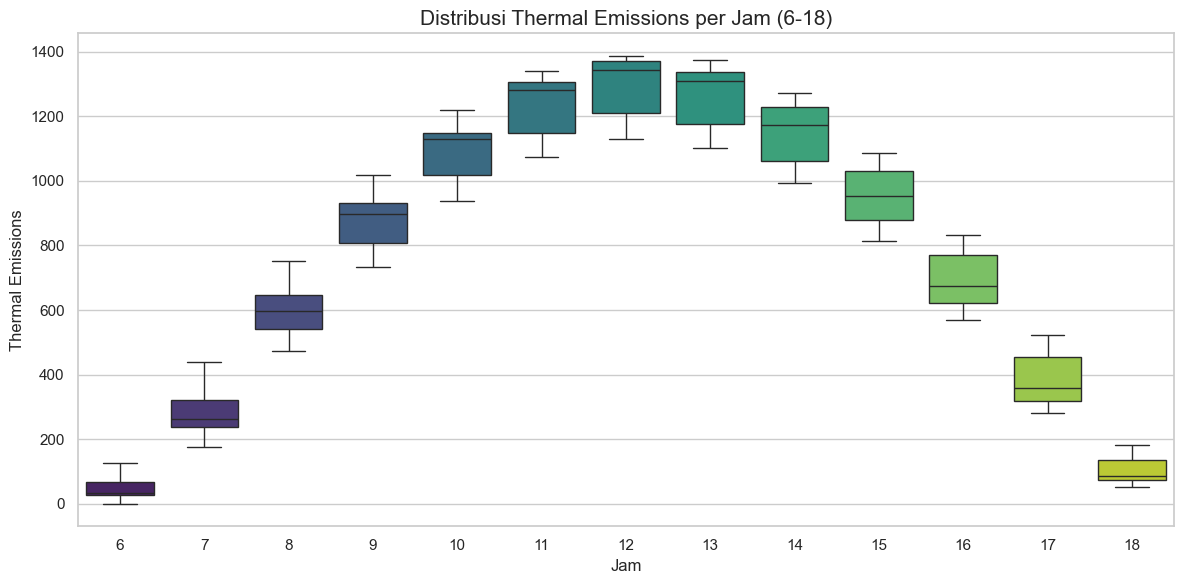

In [10]:
# Atur style seaborn untuk plot yang lebih menarik (opsional)
sns.set_theme(style="whitegrid")

# 3. Buat box plot untuk setiap fitur
for feature in features:
    plt.figure(figsize=(12, 6)) # Atur ukuran figure
    sns.boxplot(x='hour', y=feature, data=df_daytime, palette="viridis")
    plt.title(f'Distribusi {feature.replace("_", " ").title()} per Jam (6-18)', fontsize=15)
    plt.xlabel('Jam', fontsize=12)
    plt.ylabel(feature.replace("_", " ").title(), fontsize=12)
    # Jika ada banyak jam, rotasi label x-axis bisa membantu
    # plt.xticks(rotation=45)
    plt.tight_layout() # Menyesuaikan layout agar tidak tumpang tindih
    plt.show()

In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

features = [
    'downwelling_light',
    'scattered_light',
    'perpendicular_light_intensity',
    'photoperiod_intensity',
    'total_light_exposure',
    'thermal_emissions'
]

# 1. Filter DataFrame untuk jam 6 hingga 18 (di mana imputasi relevan)
df_daytime = df[(df['hour'] >= 6) & (df['hour'] <= 18)].copy()

# Simpan indeks asli untuk menggabungkan kembali nanti
original_daytime_index = df_daytime.index

In [12]:
# 2. Kolom yang akan digunakan oleh KNNImputer
# Kita akan menggunakan 'hour' dan fitur-fitur yang akan diimputasi itu sendiri
# untuk mencari tetangga terdekat.
knn_features = ['hour'] + features
df_for_imputation = df_daytime[knn_features].copy()

# Cek jumlah missing values sebelum imputasi (opsional)
print("Missing values SEBELUM imputasi (pada jam 6-18):")
print(df_for_imputation[features].isnull().sum())
print("-" * 30)

Missing values SEBELUM imputasi (pada jam 6-18):
downwelling_light                 510
scattered_light                   284
perpendicular_light_intensity    1357
photoperiod_intensity            2441
total_light_exposure              459
thermal_emissions                2313
dtype: int64
------------------------------


In [13]:
# --- SIMPAN DATA SEBELUM IMPUTASI UNTUK PERBANDINGAN ---
# Buat salinan dari kolom yang akan diimputasi SEBELUM proses imputasi
# df_before_imputation_values akan memiliki indeks yang sama dengan df_daytime (yaitu original_daytime_index)
df_before_imputation_values = df_for_imputation[features].copy()
# Identifikasi di mana NaN berada pada data SEBELUM imputasi
nan_mask_original = df_before_imputation_values.isnull()

print("Missing values SEBELUM imputasi KNN (pada jam 6-18, fitur terpilih):")
print(df_for_imputation[features].isnull().sum().loc[lambda x: x > 0]) # Hanya tampilkan yg ada NaN
print("-" * 30)

if df_for_imputation[features].isnull().any().any():
    scaler = StandardScaler()
    scaled_columns = df_for_imputation.columns
    df_scaled_array = scaler.fit_transform(df_for_imputation)
    df_scaled = pd.DataFrame(df_scaled_array, columns=scaled_columns, index=df_for_imputation.index)

    imputer = KNNImputer(n_neighbors=min(3, len(df_scaled)-1 if len(df_scaled)>1 else 1)) # n_neighbors tidak boleh > n_samples
    df_imputed_scaled_array = imputer.fit_transform(df_scaled)
    df_imputed_scaled = pd.DataFrame(df_imputed_scaled_array, columns=scaled_columns, index=df_for_imputation.index)

    df_imputed_original_scale_array = scaler.inverse_transform(df_imputed_scaled)
    df_imputed_original_scale = pd.DataFrame(df_imputed_original_scale_array, columns=scaled_columns, index=df_for_imputation.index)

    # Gabungkan kembali nilai yang sudah diimputasi ke DataFrame df utama
    for col in features:
        # df_imputed_original_scale memiliki indeks yang sama dengan df_daytime (original_daytime_index)
        df.loc[original_daytime_index, col] = df_imputed_original_scale[col]

    print("\nMissing values SETELAH imputasi KNN (pada jam 6-18, fitur terpilih):")
    print(df.loc[original_daytime_index, features].isnull().sum().loc[lambda x: x > 0]) # Harusnya kosong jika semua terimputasi
    print("-" * 30)

    # --- TAMPILKAN PERBANDINGAN ---
    print("Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi):")
    any_imputed = False
    for feature in features:
        # Dapatkan indeks dari df_daytime (original_daytime_index) di mana fitur ini awalnya NaN
        idx_nan_in_feature = nan_mask_original[nan_mask_original[feature]].index

        if not idx_nan_in_feature.empty:
            any_imputed = True
            print(f"\n--- Fitur: {feature} ---")
            # Nilai sebelum diambil dari salinan yang kita buat
            before_values = df_before_imputation_values.loc[idx_nan_in_feature, feature]
            # Nilai sesudah diambil dari df utama yang sudah diupdate
            # idx_nan_in_feature adalah indeks global yang valid untuk df
            after_values = df.loc[idx_nan_in_feature, feature]

            comparison_df = pd.DataFrame({
                'Jam': df.loc[idx_nan_in_feature, 'hour'], # Ambil jam dari df utama
                'Sebelum': before_values,
                'Sesudah': after_values.round(4) # Pembulatan untuk tampilan
            })
            # Set indeks agar lebih mudah dibaca jika diperlukan (opsional)
            # comparison_df = comparison_df.set_index(idx_nan_in_feature)
            print(comparison_df)
    if not any_imputed:
        print("Tidak ada nilai spesifik yang teridentifikasi telah diimputasi (mungkin tidak ada NaN awal).")

else:
    print("Tidak ada missing values pada fitur target di jam 6-18 untuk diimputasi dengan KNN.")

# print("\nDataFrame df setelah semua proses (cuplikan jam 6-18):")
# print(df[df['hour'].between(6,18)][['hour'] + features].head(15).to_string())

Missing values SEBELUM imputasi KNN (pada jam 6-18, fitur terpilih):
downwelling_light                 510
scattered_light                   284
perpendicular_light_intensity    1357
photoperiod_intensity            2441
total_light_exposure              459
thermal_emissions                2313
dtype: int64
------------------------------

Missing values SETELAH imputasi KNN (pada jam 6-18, fitur terpilih):
Series([], dtype: int64)
------------------------------
Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi):

--- Fitur: downwelling_light ---
       Jam  Sebelum   Sesudah
185     17      NaN   27.3333
203     11      NaN  256.0000
210     18      NaN    0.6667
232     16      NaN   35.3333
271      7      NaN   38.3333
...    ...      ...       ...
21566   14      NaN  534.0000
21685   13      NaN  438.0000
21801    9      NaN  419.3333
21826   10      NaN  303.0000
21850   10      NaN  577.6667

[510 rows x 3 columns]

--- Fitur: scattered_light ---
      

In [14]:
print("\nDataFrame df setelah semua proses (cuplikan jam 6-18):")
print(df[df['hour'].between(6,18)][['hour'] + features].head(15).to_string())


DataFrame df setelah semua proses (cuplikan jam 6-18):
    hour  downwelling_light  scattered_light  perpendicular_light_intensity  photoperiod_intensity  total_light_exposure  thermal_emissions
6      6                1.0             12.0                      17.966667               0.000000                  13.0          76.933333
7      7               69.0             84.0                     285.100000              60.000000                 153.0         342.400000
8      8              257.0            116.0                     551.800000              60.000000                 373.0         586.133333
9      9              484.0            135.0                     731.900000              60.000000                 619.0         935.400000
10    10              606.0            146.0                     743.200000              60.000000                 752.0        1153.400000
11    11              690.0            198.0                     752.000000              60.000000      

In [15]:
df.to_csv('data/fitur_clean/light.csv', index=False)

In [16]:
# 1. Hitung jumlah missing values (NaN) per kolom
missing_counts = df.isnull().sum()

# 2. Urutkan hasil perhitungan tersebut dari yang terkecil ke terbesar
sorted_missing_counts = missing_counts.sort_values()

# 3. Tampilkan hasilnya
print("Jumlah Missing Values per Kolom (Terurut dari Paling Sedikit):")
print(sorted_missing_counts)

# 4. (Opsional) Jika Anda ingin membuat DataFrame baru dengan kolom yang sudah terurut
#    berdasarkan jumlah missing values:
sorted_columns = sorted_missing_counts.index.tolist()
df_sorted_by_missing = df[sorted_columns]

print("\nDataFrame dengan Kolom Terurut Berdasarkan Jumlah Missing Value (Paling Sedikit Dulu):")
print(df_sorted_by_missing.head()) # Tampilkan beberapa baris pertama

Jumlah Missing Values per Kolom (Terurut dari Paling Sedikit):
measurement_id                                      0
day                                                 0
month                                               0
year                                                0
total_light_exposure                                0
photoperiod_intensity                               0
is_photic_zone                                      0
thermal_emissions                                   0
hour                                                0
scattered_light                                     0
downwelling_light                                   0
perpendicular_light_intensity                       0
dayofweek                                           0
depth_reading_time                                  0
chlorophyll_a_concentration (mg m-3)             1328
bottom_current_shear_stress (Pa)                 1379
perceived_water_density                          1407
total_alkalinity (µ